# **Población mundial 1970–2022: tendencias y densidad**

***Autor***: Salvador Chacon

## **Definicion del problema**

El siguiente DataSet reúne series históricas de población por país/territorio (1970–2022) y añade contexto geográfico y demográfico: continente, capital, área (km²), densidad, tasa de crecimiento, ranking y % de la población mundial. Permite comparar niveles y tendencias, identificar países en expansión o descenso, analizar densidad y participación por continente

Preguntas como:

* ¿El crecimiento global se desaceleró? ¿Cuál es el CAGR por década del total mundial y como es su pendiente?
* ¿Cambia la participación por continentes?¿Cómo varió el share de África, Asia, America y Europa en la población mundial entre 1970 y 2022 y cuál es la pendiente por continente?
* ¿Qué porcentaje del total 2022 concentran los top 10 países y cuál es el índice de Gini/Herfindahl de la distribución de World Population Percentage?
* ¿Qué porcentaje del aumento absoluto global proviene de países con mas de 100M habitantes y cuánto aporta cada continente a ese aumento?

Serviran de guia para el analisis de este DataSet, con la intencion de responder a hipotesis como:

* África aumentó su participación del total mundial.
* Asia sigue liderando en nivel, pero su crecimiento se desacelera.
* Europa está estancada o en leve caída.
* La distribución del mundo por país es muy concentrada.
* Existe una desaceleración del crecimiento global
* La participación de América Latina esta estancada



## **Fuente, estructura del dataset y transformaciones realizadas**

-Fuente original: Dataset ´World Population by Country (1970-2022)´ tomado de Kaggle y alojado en mi repositorio de Github bajo el nombre world_pupulation.csv

-Columnas:

Country/Territory, Capital, Continent

Población por año: 1970, 1980, …, 2022.

Variables adicionales: Area (km²), Density (per km²), Growth Rate, World Population Percentage.

Transformaciones clave realizadas:


*   Suma por año para obtener población mundial total (la serie year_population_data).
*   Cálculo de tasas usando log de poblaciones y tramos (1970–1980, etc.) en la parte del model de ML.
*   Log-transform de población inicial para estabilizar la varianza.

## **Carga y preparacion de datos**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
url = "https://raw.githubusercontent.com/salvador551998/Salvador-Chacon-/refs/heads/main/world_population.csv"
df_population = pd.read_csv(url)

### **Exploracion inicial**

In [ ]:
df_population.head()

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00


In [ ]:
df_population.describe()

,Rank,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
count,234.000000,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,2.340000e+02,234.000000,234.000000,234.000000
mean,117.500000,3.407441e+07,3.350107e+07,3.172996e+07,2.984524e+07,2.626947e+07,2.271022e+07,1.898462e+07,1.578691e+07,5.814494e+05,452.127044,1.009577,0.427051
std,67.694165,1.367664e+08,1.355899e+08,1.304050e+08,1.242185e+08,1.116982e+08,9.783217e+07,8.178519e+07,6.779509e+07,1.761841e+06,2066.121904,0.013385,1.714977
min,1.000000,5.100000e+02,5.200000e+02,5.640000e+02,5.960000e+02,6.510000e+02,7.000000e+02,7.330000e+02,7.520000e+02,1.000000e+00,0.026100,0.912000,0.000000
25%,59.250000,4.197385e+05,4.152845e+05,4.046760e+05,3.931490e+05,3.272420e+05,2.641158e+05,2.296142e+05,1.559970e+05,2.650000e+03,38.417875,1.001775,0.010000
50%,117.500000,5.559944e+06,5.493074e+06,5.307400e+06,4.942770e+06,4.292907e+06,3.825410e+06,3.141146e+06,2.604830e+06,8.119950e+04,95.346750,1.007900,0.070000
75%,175.750000,2.247650e+07,2.144798e+07,1.973085e+07,1.915957e+07,1.576230e+07,1.186923e+07,9.826054e+06,8.817329e+06,4.304258e+05,238.933250,1.016950,0.280000
max,234.000000,1.425887e+09,1.424930e+09,1.393715e+09,1.348191e+09,1.264099e+09,1.153704e+09,9.823725e+08,8.225344e+08,1.709824e+07,23172.266700,1.069100,17.880000


In [ ]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rank                         234 non-null    int64  
 1   CCA3                         234 non-null    object 
 2   Country/Territory            234 non-null    object 
 3   Capital                      234 non-null    object 
 4   Continent                    234 non-null    object 
 5   2022 Population              234 non-null    int64  
 6   2020 Population              234 non-null    int64  
 7   2015 Population              234 non-null    int64  
 8   2010 Population              234 non-null    int64  
 9   2000 Population              234 non-null    int64  
 10  1990 Population              234 non-null    int64  
 11  1980 Population              234 non-null    int64  
 12  1970 Population              234 non-null    int64  
 13  Area (km²)          

In [ ]:
df_population.isna().sum()

,0
Rank,0
CCA3,0
Country/Territory,0
Capital,0
Continent,0
2022 Population,0
2020 Population,0
2015 Population,0
2010 Population,0
2000 Population,0


In [ ]:
df_population['Country/Territory'].value_counts()
df_population['Continent'].value_counts()

,count
Continent,
Africa,57
Asia,50
Europe,50
North America,40
Oceania,23
South America,14


## **EDA (Analisis exploratorio de datos)**

### **Tendencia de la poblacion global**

In [ ]:
#Se suma todos los valores de cada columna en una sola entrada por año y se crea una serie para almacenar estos datos

years = ['1970 Population', '1980 Population','1990 Population', '2000 Population', '2010 Population', '2015 Population', '2020 Population','2022 Population']
total_year_population = {year: df_population[year].sum() for year in years}
print(total_year_population)

year_population_data = pd.Series(total_year_population)
year_population_data.index = year_population_data.index.str[:4]
year_population_data

{'1970 Population': np.int64(3694136661), '1980 Population': np.int64(4442400371), '1990 Population': np.int64(5314191665), '2000 Population': np.int64(6147055703), '2010 Population': np.int64(6983784998), '2015 Population': np.int64(7424809761), '2020 Population': np.int64(7839250603), '2022 Population': np.int64(7973413042)}


,0
1970,3694136661
1980,4442400371
1990,5314191665
2000,6147055703
2010,6983784998
2015,7424809761
2020,7839250603
2022,7973413042


Text(0, 0.5, 'Poblacion (Billones)')

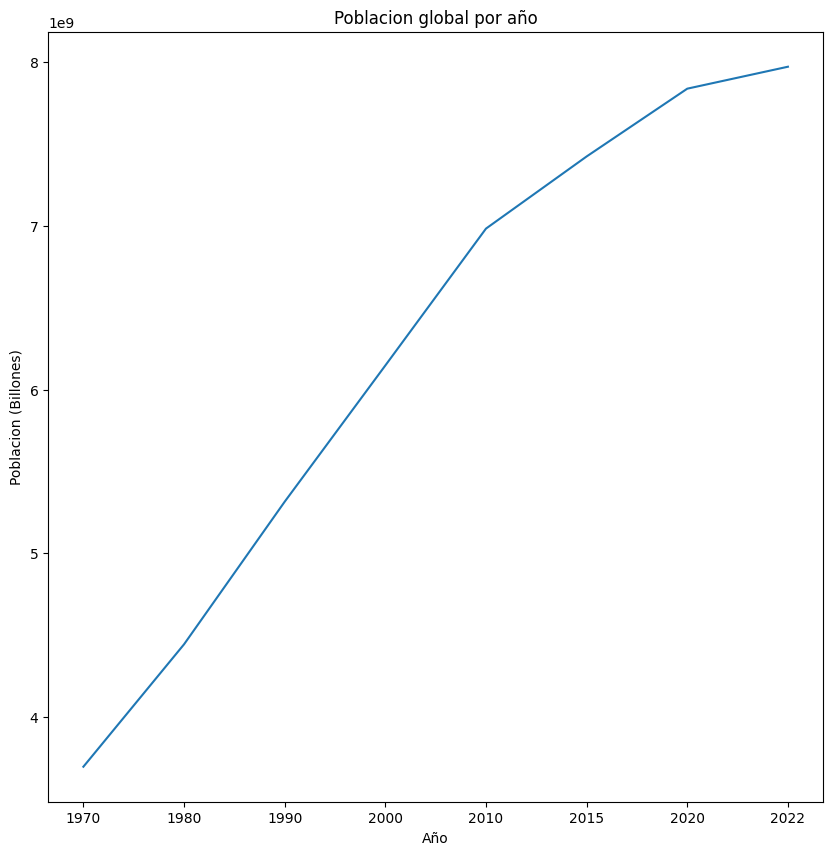

In [ ]:
#Se crea un grafico de linea para analizar la tendencia de la poblacion global a lo largo del tiempo

plt.figure(figsize = (10,10))
sns.lineplot(data = year_population_data)
plt.title("Poblacion global por año")
plt.xlabel("Año")
plt.ylabel("Poblacion (Billones)")

Del grafico anterior podemos observar que:

*   La población mundial creció de ~3.700 millones en 1970 a ~8.000 millones en 2022 — un aumento de 4.300 millones en 52 años.
*   Entre 1970 y 2010, el crecimiento promedió más de 1.000 millones por década (~100 millones por año).
*   Después de 2010, el crecimiento se redujo a menos de 1.000 millones en la década.
*   Entre 2020 y 2022, solo se sumaron 100 millones, lo que sugiere que la década de 2020 podría registrar la mitad del crecimiento de décadas anteriores.

### **Cálculo de CAGR global por década**

In [ ]:
world = year_population_data.sort_index()
filas = []

for i in range(len(world) - 1):
    y0 = int(world.index[i])
    y1 = int(world.index[i+1])
    n = y1 - y0
    p0 = world.iloc[i]
    p1 = world.iloc[i+1]
    cagr = (p1 / p0)**(1/n) - 1

    filas.append({
        "Periodo": f"{y0}-{y1}",
        "CAGR": cagr
    })

df_cagr = pd.DataFrame(filas)
df_cagr


,Periodo,CAGR
0,1970-1980,0.018616
1,1980-1990,0.018080
2,1990-2000,0.014666
3,2000-2010,0.012844
4,2010-2015,0.012323
5,2015-2020,0.010922
6,2020-2022,0.008521


CAGR = (Pfinal​/Pinicial​)^(1/n) - 1 , donde n es el numero de años del periodo.

### **Poblacion por contiente**

In [ ]:
continent_year_population = df_population.groupby("Continent")[years].sum().reset_index()
continent_year_population_data = pd.melt(continent_year_population,
                                         id_vars = ['Continent'],
                                         var_name = 'Years',
                                         value_name = 'Population')
continent_year_population_data["Years"] = (
    continent_year_population_data["Years"].str.replace(" Population", "")
)
continent_year_population_data.head()
continent_year_population

,Continent,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,2015 Population,2020 Population,2022 Population
0,Africa,365444348,481536377,638150629,818946032,1055228072,1201102442,1360671810,1426730932
1,Asia,2144906290,2635334228,3210563577,3735089604,4220041327,4458250182,4663086535,4721383274
2,Europe,655923991,692527159,720320797,726093423,735613934,741535608,745792196,743147538
3,North America,315434606,368293361,421266425,486069584,542720651,570383850,594236593,600296136
4,Oceania,19480270,22920240,26743822,31222778,37102764,40403283,43933426,45038554
5,South America,192947156,241789006,297146415,349634282,393078250,413134396,431530043,436816608


Text(0, 0.5, 'Poblacion (Billones)')

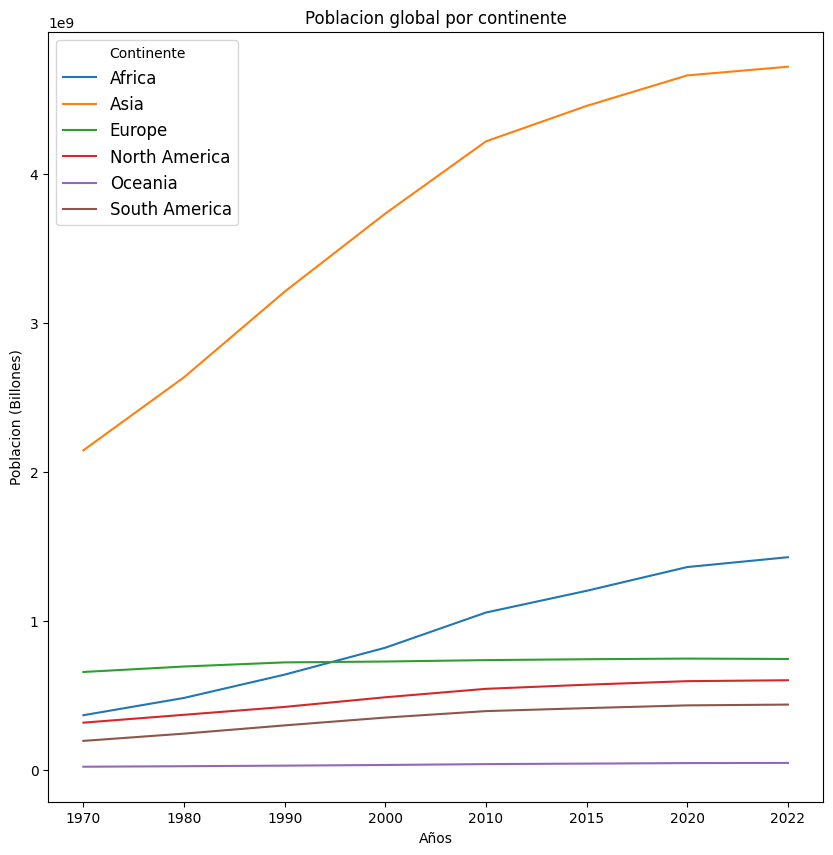

In [ ]:
#Se realiza un grafico de linea para analizar la tendencia de la poblacion global por continente a lo largo del tiempo
plt.figure(figsize = (10,10))
sns.lineplot(
    data=continent_year_population_data,
    x="Years",
    y="Population",
    hue="Continent"
)
plt.legend(title="Continente", loc="upper left", fontsize='large')
plt.title("Poblacion global por continente")
plt.xlabel("Años")
plt.ylabel("Poblacion (Billones)")

Del grafico anterior podemos observar que:

*   Oceanía: La población más pequeña, con un crecimiento constante de aproximadamente 4 millones por década.
*   América: Una de las poblaciones más pequeñas con un crecimiento moderado (~50 millones por década), que se desaceleró ligeramente después de 2010.
*   Europa: Crecimiento constante hasta 1990 (~40 millones por década), luego una ligera disminución.
*   África: Experimentó grandes aumentos, pasando de ~350 millones a ~1.500 millones (entre 100 y 200 millones por década).
*   Asia: Creció drásticamente de ~ 2.000 millones a ~ 4.500 millones, con el mayor incremento entre 1970 y 2000 (~500 millones por década).
*   En general: El crecimiento poblacional fue constante en los continentes, con Asia y África como los principales contribuyentes.

### **Distribucion de poblacion entre paises**

Text(0, 0.5, 'Numero de paises')

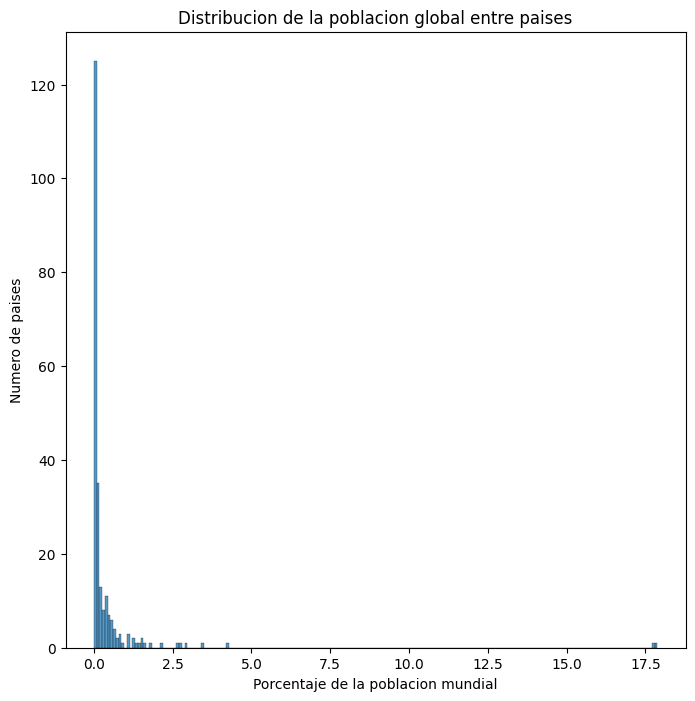

In [ ]:
#Se realizaz un grafico de barras para analizar como esta distribuida la poblacion mundial a lo largo de los paises

population_distribution = df_population[['Country/Territory', 'World Population Percentage']]

plt.figure(figsize = (8, 8))
sns.histplot(population_distribution['World Population Percentage'])
plt.title("Distribucion de la poblacion global entre paises")
plt.xlabel("Porcentaje de la poblacion mundial")
plt.ylabel("Numero de paises")

(0.0, 4.5)

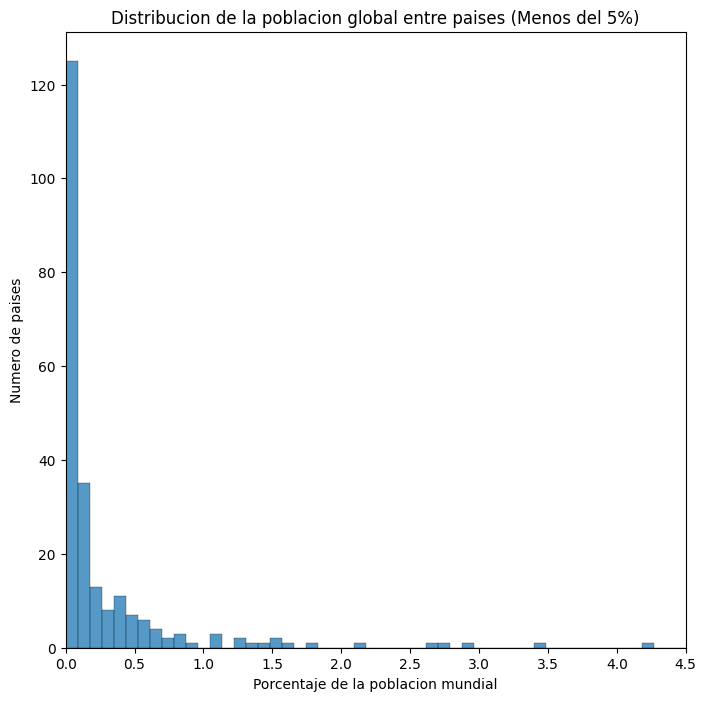

In [ ]:
#Se realizaz el mismo grafico anterior pero solamente para el 5% de la poblacion mundial para entender como está esta distribuida


plt.figure(figsize = (8, 8))
sns.histplot(population_distribution['World Population Percentage'])
plt.title("Distribucion de la poblacion global entre paises (Menos del 5%)")
plt.xlabel("Porcentaje de la poblacion mundial")
plt.ylabel("Numero de paises")
plt.xlim(0, 4.5)

(17.5, 20.0)

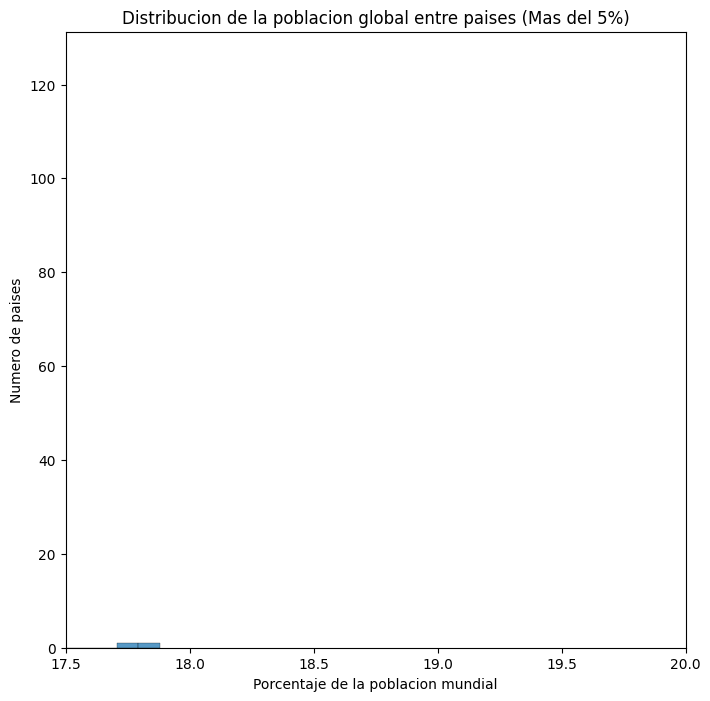

In [ ]:
#Se realizaz el mismo grafico anterior pero para el% de la poblacion mundial mayor al 5% para entender como está esta distribuida el resto de la poblacion

plt.figure(figsize = (8, 8))
sns.histplot(population_distribution['World Population Percentage'])
plt.title("Distribucion de la poblacion global entre paises (Mas del 5%)")
plt.xlabel("Porcentaje de la poblacion mundial")
plt.ylabel("Numero de paises")
plt.xlim(17.5, 20)

De los graficos anteriores podemos observar que:

*   La mayoría de los países (alrededor de 160, o un 68%) tienen menos del 0,1% de la poblacion mundial.
*   Otros ~ aprox 40 países se encuentran entre 0,1% y 0,5%.
*   Aproximadamente 20 países están entre 0,5% y 1%.
*   Alrededor de 20 países se ubican en el rango medio, con entre 1% y 4,3% de la población mundial.
*   Dos países concentran casi el 18% de la población mundial cada uno.

Esto muestra que alrededor del 70% de los países contribuyen con menos del 1% a la población mundial, mientras que un número reducido de países más grandes concentra la mayor parte del resto.

### **Area vs densidad de un pais**

Text(0, 0.5, 'Densidad (por km²)')

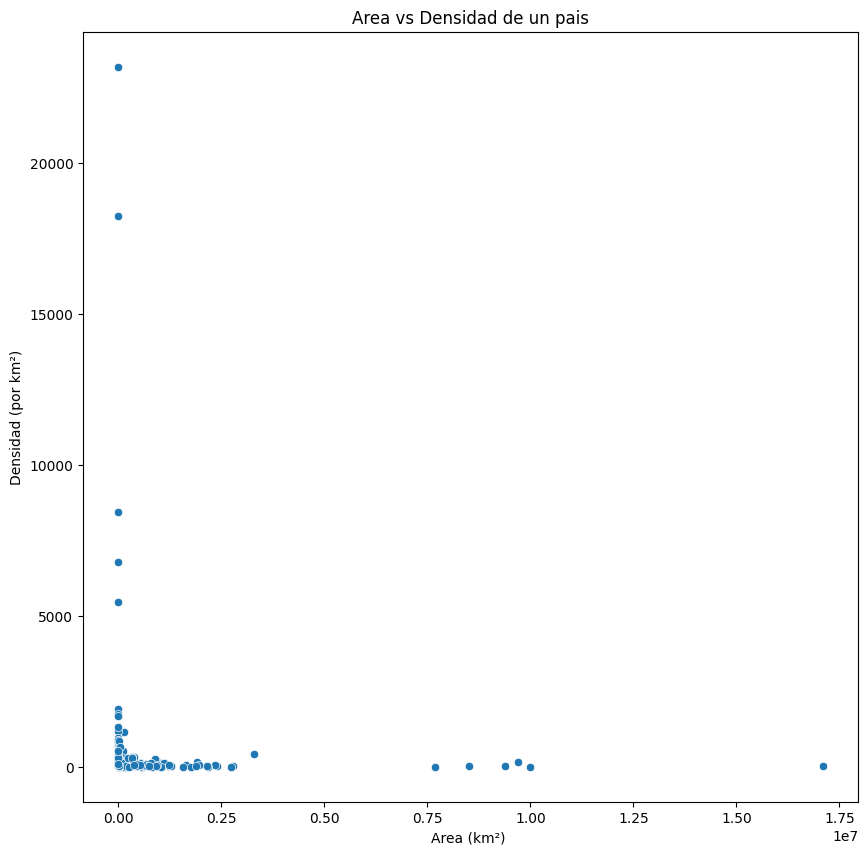

In [ ]:
#Se realiza un scatter plot para ver como es la relacion a simple vista entre el area y la densidad de un pais

plt.figure(figsize = (10,10))
sns.scatterplot(x = df_population['Area (km²)'], y = df_population['Density (per km²)'])
plt.title("Area vs Densidad de un pais")
plt.xlabel("Area (km²) ")
plt.ylabel("Densidad (por km²)")

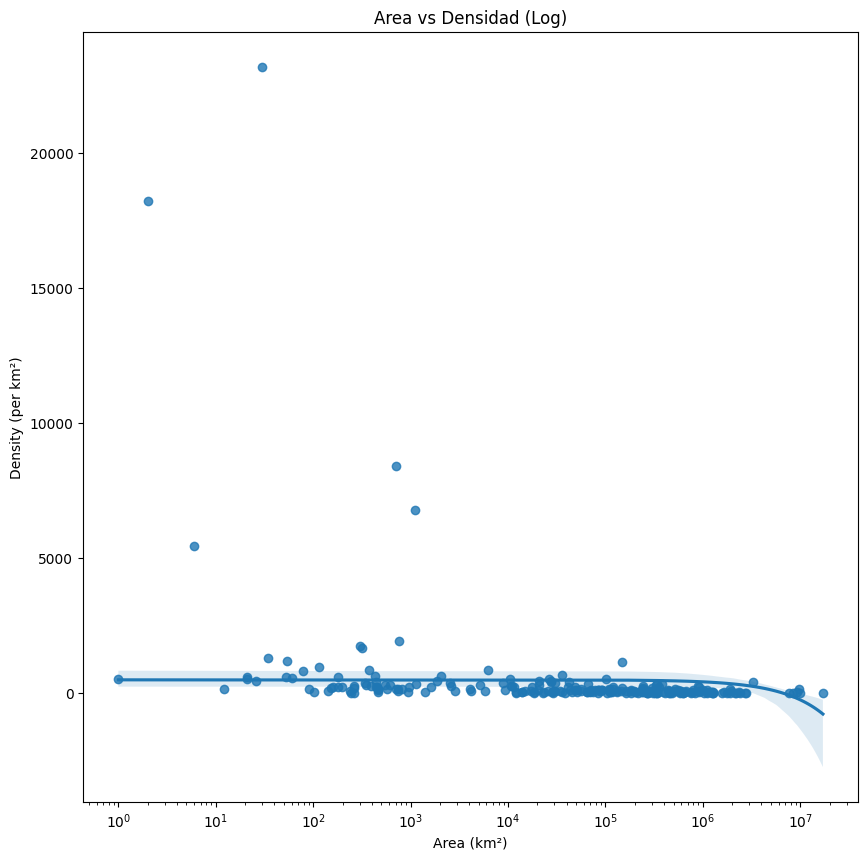

In [ ]:
#Se realiza un el mismo grafico anterior pero con una linea de tendencia y un ajuste logaritmico

plt.figure(figsize = (10,10))
sns.regplot(x = df_population['Area (km²)'], y = df_population['Density (per km²)'])
plt.title("Area vs Densidad (Log)")
plt.xscale("log")

(0.0, 1000.0)

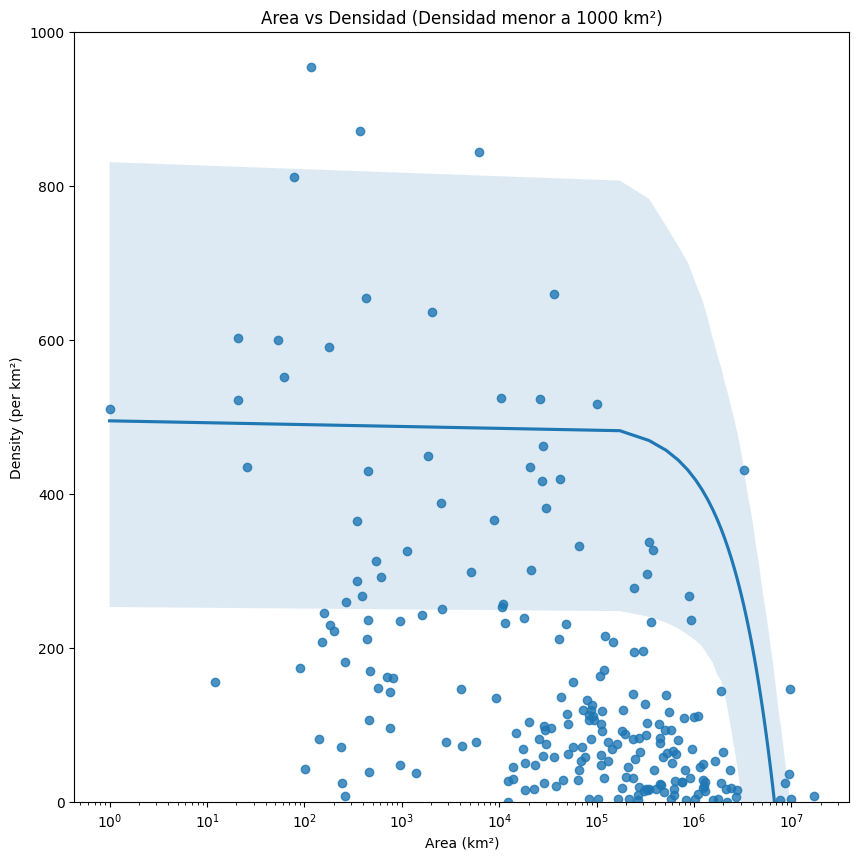

In [ ]:
plt.figure(figsize = (10,10))
sns.regplot(x = df_population['Area (km²)'], y = df_population['Density (per km²)'])
plt.title("Area vs Densidad (Densidad menor a 1000 km²)")
plt.xscale("log")
plt.ylim(0, 1000)

De los graficos anteriores podemos observar que:

*   Existe una tendencia general en la que los países/territorios más grandes tienden a tener densidades de población más bajas.
*   La mayoría de los países/territorios medianos a grandes tienen una densidad de población de alrededor de 100 personas por km².
*   Los países/territorios más pequeños muestran un rango más amplio de densidades, típicamente entre 100 y 700 personas por km².
*   Unos pocos países/territorios pequeños (5 en este conjunto de datos) tienen densidades extremadamente altas, con más de 5000 personas por km².

## **Prediccion de futuras poblaciones (ML)**

El objetivo sera predecir la poblacion de un pais en los proximos 5-10 años en base a la informacion anterior

### **Modelo Ridge**

In [ ]:
df = df_population.copy()

# features
year_cols = [c for c in df.columns if re.fullmatch(r'\d{4}\sPopulation', c) and c != '2022 Population']
extra_num = [c for c in ['Area (km²)', 'Density (per km²)', 'Growth Rate', 'World Population Percentage'] if c in df.columns]
num_cols = year_cols + extra_num
cat_cols = [c for c in ['Continent'] if c in df.columns]

X = df[cat_cols + num_cols].copy()
y = pd.to_numeric(df['2022 Population'], errors='coerce')

# preparacion
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn ≥1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)         # sklearn <1.2

pre_core = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', ohe, cat_cols)
], remainder='drop')

# Modelo Ridge
pipe = Pipeline([
    ('pre', pre_core),
    ('model', Ridge(alpha=1.0, random_state=1))
])

# entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
pipe.fit(X_train, y_train)

preds = pipe.predict(X_val)
print("MAE:", round(mean_absolute_error(y_val, preds), 2))
print("R2 :", round(r2_score(y_val, preds), 4))

MAE: 501770.31
R2 : 0.9992


### **Comparación de modelos (Ridge vs Random Forest vs XGBoost)**

In [ ]:
modelos = {
    "Ridge": Ridge(alpha=1.0, random_state=1),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=1,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=1
    )
}

resultados = []

for nombre, reg in modelos.items():
    pipe = Pipeline([
        ('pre', pre_core),
        ('model', reg)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    mae = mean_absolute_error(y_val, preds)

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_val, preds)

    resultados.append({
        "Modelo": nombre,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

df_metricas = pd.DataFrame(resultados)
df_metricas


,Modelo,MAE,RMSE,R²
0,Ridge,5.017703e+05,7.342024e+05,0.999162
1,RandomForest,2.386436e+06,7.382453e+06,0.915303
2,XGBoost,5.404976e+05,9.735339e+05,0.998527


En la comparación de modelos, el Ridge obtiene el mejor desempeño global: presenta el MAE y el RMSE más bajos y un R² ≈ 0,999, lo que indica que explica casi toda la variabilidad de la población a partir de las variables históricas. XGBoost también muestra un ajuste muy alto (R² ≈ 0,999), pero con errores algo mayores, mientras que el Random Forest queda claramente por detrás, con errores varias veces superiores y un R² sensiblemente menor. Dado este resultado, el modelo lineal regularizado (Ridge) se mantiene como la opción más precisa y estable para realizar las proyecciones en este conjunto de datos.

### **Predicciones del modelo para 2025**

In [ ]:
df = df_population.copy()

#Columnas opcionales
area_col = 'Area (km²)' if 'Area (km²)' in df.columns else None
continent_col = 'Continent' if 'Continent' in df.columns else None

# Armado de dataset de entrenamiento con tramos históricos
pairs = [(1970,1980),(1980,1990),(1990,2000),(2000,2010),(2010,2015),(2015,2020),(2020,2022)]
rows = []
for (y0, y1) in pairs:
    c0, c1 = f'{y0} Population', f'{y1} Population'
    if c0 in df.columns and c1 in df.columns:
        start_pop = pd.to_numeric(df[c0], errors='coerce')
        end_pop   = pd.to_numeric(df[c1], errors='coerce')
        ok = start_pop.gt(0) & end_pop.gt(0)
        tmp = pd.DataFrame({
            'Country/Territory': df['Country/Territory'],
            'start_year': y0,
            'log_start_pop': np.log(start_pop.where(ok)),
            'annual_log_growth': (np.log(end_pop.where(ok)) - np.log(start_pop.where(ok))) / (y1 - y0)
        })
        if area_col:
            tmp[area_col] = pd.to_numeric(df[area_col], errors='coerce')
        if continent_col:
            tmp[continent_col] = df[continent_col]
        rows.append(tmp)

train_df = pd.concat(rows, ignore_index=True).dropna()

#features y target
num_cols = ['log_start_pop', 'start_year']
if area_col: num_cols.append(area_col)
cat_cols = [continent_col] if continent_col else []

X = train_df[num_cols + cat_cols].copy()
y = train_df['annual_log_growth'].copy()

# preprocesamiento + modelo
num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

transformers = [('num', num_pipe, num_cols)]
if cat_cols:
    transformers.append(('cat', ohe, cat_cols))

pre_growth = ColumnTransformer(transformers, remainder='drop')
pipe_growth = Pipeline([('pre', pre_growth), ('model', Ridge(alpha=1.0, random_state=1))])

pipe_growth.fit(X, y)

#predicción 2025
assert '2022 Population' in df.columns, "Falta la columna '2022 Population' en df_population"
pop_2022 = pd.to_numeric(df['2022 Population'], errors='coerce').clip(lower=1)

feat_pred = pd.DataFrame({
    'Country/Territory': df['Country/Territory'],
    'start_year': 2022,
    'log_start_pop': np.log(pop_2022),
})
if area_col:
    feat_pred[area_col] = pd.to_numeric(df[area_col], errors='coerce')
if continent_col:
    feat_pred[continent_col] = df[continent_col]

X_pred = feat_pred[num_cols + cat_cols]
annual_log_g_hat = pipe_growth.predict(X_pred)
h = 3
pred_2025 = np.exp(feat_pred['log_start_pop'] + annual_log_g_hat * h)

#salida
out = pd.DataFrame({
    'Country/Territory': feat_pred['Country/Territory'],
    'Continent': df[continent_col] if continent_col else None,
    'Predicted_2025': pred_2025.round(0).astype('Int64')
}).sort_values('Predicted_2025', ascending=False).reset_index(drop=True)

out

,Country/Territory,Continent,Predicted_2025
0,China,Asia,1478373333
1,India,Asia,1469892175
2,United States,North America,342452924
3,Indonesia,Asia,286163833
4,Pakistan,Asia,244998093
...,...,...,...
229,Montserrat,North America,4488
230,Falkland Islands,South America,3904
231,Niue,Oceania,1972
232,Tokelau,Oceania,1908


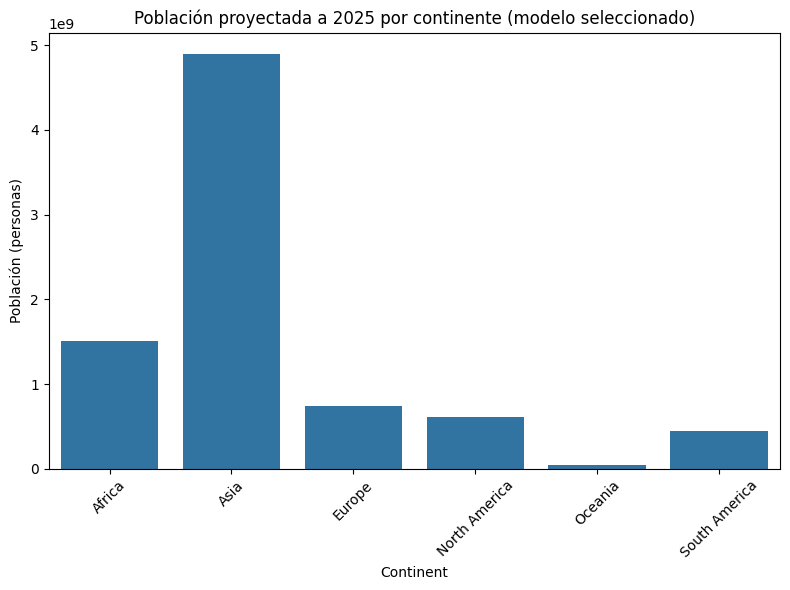

,Continent,Pop_2025,Share_%
0,Africa,1509782927,18.301202
1,Asia,4901313717,59.412471
2,Europe,737432088,8.938963
3,North America,608269243,7.373284
4,Oceania,45578670,0.552493
5,South America,447261263,5.421587


In [ ]:
#Se arma un grafico por contienente de las proyecciones 2025

pred_cont = (
    out.groupby("Continent", as_index=False)["Predicted_2025"]
       .sum()
       .rename(columns={"Predicted_2025": "Pop_2025"})
)

pred_cont["Share_%"] = 100 * pred_cont["Pop_2025"] / pred_cont["Pop_2025"].sum()

plt.figure(figsize=(8,6))
sns.barplot(data=pred_cont, x="Continent", y="Pop_2025")
plt.title("Población proyectada a 2025 por continente")
plt.ylabel("Población (personas)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pred_cont


En las proyecciones para 2025, Asia concentra cerca del 60 % de la población mundial estimada, manteniéndose como el continente claramente predominante. África aparece como el segundo polo demográfico, con algo más del 18 %, mostrando el peso creciente de sus tasas de crecimiento frente a regiones más envejecidas como Europa y Norteamérica. América del Sur y Oceanía representan porciones mucho menores del total (≈5 % y <1 %), lo que sugiere que los cambios estructurales en la distribución mundial de la población dependen principalmente de la dinámica asiática y africana. Estas proyecciones surgen del modelo ajustado con datos históricos, por lo que no contemplan shocks fuertes (crisis, guerras, migraciones masivas) que podrían alterar estas tendencias.

## **Conclusiones finales**



Luego del análisis realizado, retomamos las hipótesis iniciales y podemos concluir lo siguiente:

En primer lugar, el crecimiento de la población mundial sigue siendo positivo, pero las tasas promedio por década muestran una **desaceleración progresiva**. Es decir, la población continúa aumentando en términos absolutos, pero cada década crece a un ritmo relativamente menor, en línea con procesos de transición demográfica y envejecimiento en varias regiones.

En segundo lugar, la **distribución regional** confirma una fuerte concentración estructural: Asia explica la mayor parte de la población mundial y África incrementa su participación de manera sostenida, mientras que Europa y América Latina tienden a estabilizarse o a perder peso relativo. La mayoría de los países aportan solo una fracción pequeña al total, mientras que un grupo reducido de países muy poblados concentra una proporción significativa de la población global.

Desde el punto de vista del modelado, la comparación entre Ridge, Random Forest y XGBoost muestra que el **modelo Ridge** es el que ofrece el mejor compromiso entre precisión y estabilidad (MAE y RMSE más bajos y R² ≈ 0,999). Por este motivo se lo selecciona como modelo final para estimar la población a partir de los datos históricos disponibles.

Las **proyecciones para 2025** basadas en Ridge sugieren que Asia concentraría alrededor del 60 % de la población mundial y África algo más del 18 %, consolidándose como los principales polos demográficos, mientras que Europa, América del Sur, Norteamérica y Oceanía mantendrían participaciones notablemente menores. Estos resultados refuerzan la idea de que los cambios estructurales en la distribución de la población dependerán, sobre todo, de la dinámica asiática y africana.

Finalmente, es importante remarcar que estas conclusiones se obtienen a partir de la extrapolación de tendencias históricas y no incorporan posibles **shocks demográficos, económicos o geopolíticos** (guerras, crisis, migraciones masivas, pandemias, etc.). Por lo tanto, las proyecciones deben interpretarse como escenarios de referencia útiles para la planificación y no como predicciones deterministas sobre el futuro de la población mundial.
